In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



from pandas.tseries.offsets import MonthEnd

from sklearn.preprocessing import MinMaxScaler


from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.layers import LSTM

## Exercise 1

In the model above we reshaped the input shape to: `(num_samples, 1, 12)`, i.e. we treated a window of 12 months as a vector of 12 coordinates that we simultaneously passed to all the LSTM nodes. An alternative way to look at the problem is to reshape the input to `(num_samples, 12, 1)`. This means we consider each input window as a sequence of 12 values that we will pass in sequence to the LSTM. In principle this looks like a more accurate description of our situation. But does it yield better predictions? Let's check it.

- Reshape `X_train` and `X_test` so that they represent a set of univariate sequences
- retrain the same LSTM(6) model, you'll have to adapt the `input_shape`
- check the performance of this new model, is it better at predicting the test data?

In [3]:
df = pd.read_csv('data/cansim-0800020-eng-6674700030567901031.csv',skiprows=6,skipfooter=9,engine='python')
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')

split_date = pd.Timestamp('01-01-2011')

train = df.loc[:split_date, ['Unadjusted']]

test = df.loc[split_date:, ['Unadjusted']]



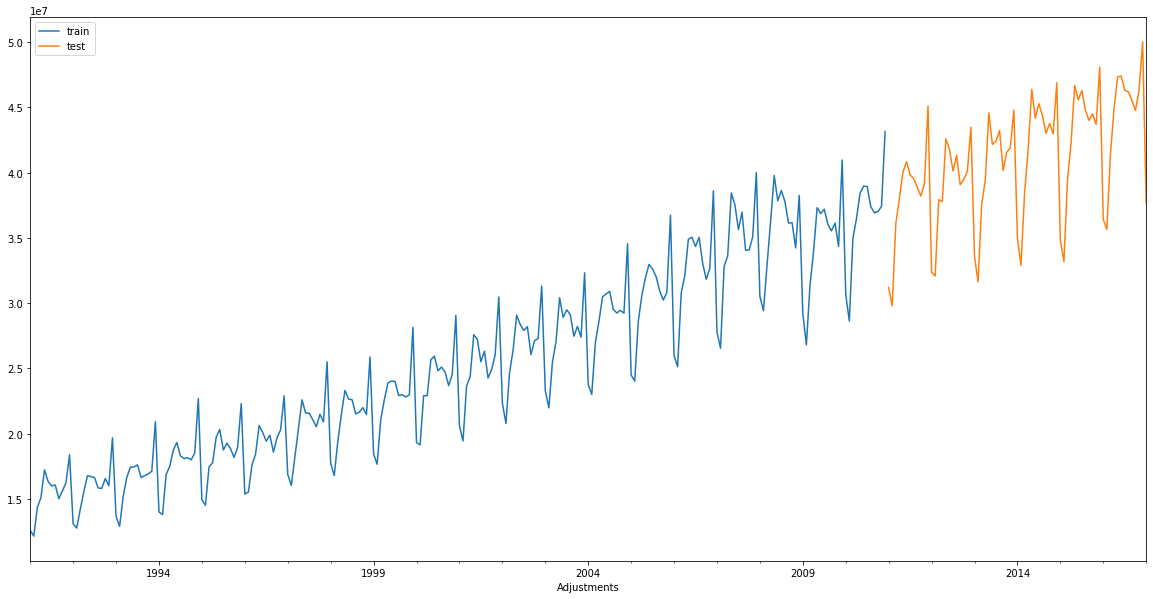

In [6]:
ax = train.plot(figsize=(20,10))
test.plot(ax=ax)
plt.legend(['train','test'],loc=2)

In [8]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)


X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]


X_train = X_train[:,None]
X_test = X_test[:,None]


train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'],index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'],index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [9]:
for s in range(1,13):
    train_sc_df[f'Shift_{s}'] = train_sc_df['Scaled'].shift(s)
    test_sc_df[f'Shift_{s}'] = test_sc_df['Scaled'].shift(s)
    
train_sc_df.head(13)

,Scaled,Shift_1,Shift_2,Shift_3,Shift_4,Shift_5,Shift_6,Shift_7,Shift_8,Shift_9,Shift_10,Shift_11,Shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [13]:
X_train = train_sc_df.dropna().drop('Scaled',axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled',axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

X_train.head()

,Shift_1,Shift_2,Shift_3,Shift_4,Shift_5,Shift_6,Shift_7,Shift_8,Shift_9,Shift_10,Shift_11,Shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [14]:
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

In [38]:
X_train_t = X_train.reshape(X_train.shape[0],12,1)
X_test_t = X_test.reshape(X_test.shape[0],12,1)

In [39]:
# 3D tensor with shape (batch_size, timesteps, input_dim)
X_train_t.shape

(228, 12, 1)

In [40]:
K.clear_session()
model = Sequential()
model.add(LSTM(6, input_shape=(12,1)))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss',patience=1,verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 192       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(X_train_t,y_train, epochs=100, batch_size=1,verbose=1,callbacks=[early_stop])
y_pred = model.predict(X_test_t)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
228/228 [==============================] - 1s 2ms/step - loss: 0.0641
Epoch 2/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 3/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 4/100
228/228 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 5/100
228/228 [=============================

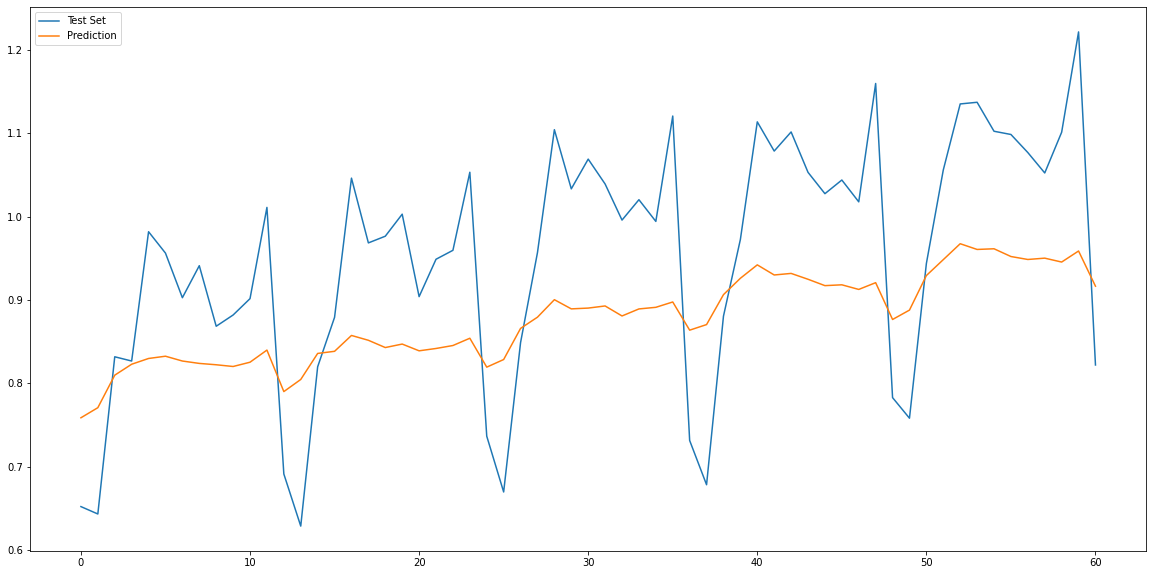

In [42]:
plt.figure(figsize=(20,10))
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test Set','Prediction'])

**This version of the model does quite poorly. The solutions video recommends removal of the early_stopper and upping epoch count. This method is below.**

In [44]:
K.clear_session()
model = Sequential()
model.add(LSTM(6, input_shape=(12,1)))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')


model.fit(X_train_t,y_train, epochs=600, batch_size=1,verbose=0)
y_pred = model.predict(X_test_t)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 192       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'poson

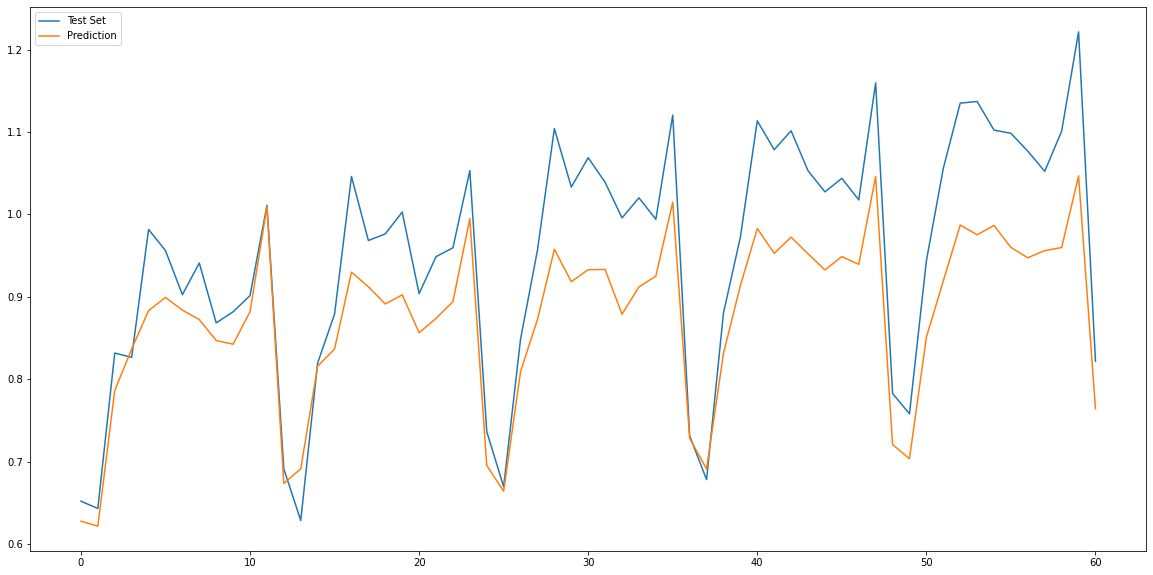

In [45]:
plt.figure(figsize=(20,10))
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(['Test Set','Prediction'])

**LSTM networks are memory intensive and require some time to train. There is a trade off between the methods mentioned in the lecture materials and this exercise. That trade off being accuracy for training time. The initial LSTM was very quick and accurate enough to get a good prediction out. This model is much more accurate, but as i write this note, the model is taking the longest in comperison to the whole course.**